- yfinance
    - conda install yfinance
    - pip install yfinance

- pandas-datareader
    - conda install pandas-datareader
    - pip install pandas-datareader

- fbprophet
    - MS C++ build tools : https://visualstudio.microsoft.com/visual-cpp-build-tools/
    - conda install -c conda-forge fbprophet
    - pip install fbprophet
    - 설치 Error 시 참고 : https://stackoverflow.com/questions/53178281/installing-fbprophet-python-on-windows-10

In [1]:
pip install yfinance

In [2]:
pip install pandas-datareader

In [6]:
pip install prophet

In [44]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from prophet import Prophet
from pandas_datareader import data

Yahoo에 있는 데이터를 가져옴

In [45]:
yf.pdr_override()

In [46]:
start_date = "2017-03-10"
end_date = "2024-07-01"
samsung = data.get_data_yahoo("005930.KS", start_date, end_date)
samsung

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-03-10,39960.0,40420.0,39860.0,40180.0,33182.230469,10227800
2017-03-13,40040.0,40980.0,40040.0,40600.0,33529.078125,7424100
2017-03-14,40620.0,41540.0,40500.0,41360.0,34156.710938,11325050
2017-03-15,40800.0,41440.0,40800.0,41400.0,34189.753906,9587850
2017-03-16,41800.0,42180.0,41540.0,41840.0,34553.109375,9933150
...,...,...,...,...,...,...
2024-06-24,79700.0,80900.0,79500.0,80600.0,80600.000000,15454227
2024-06-25,80600.0,81800.0,80100.0,80800.0,80800.000000,19088458
2024-06-26,80100.0,81400.0,79900.0,81300.0,81300.000000,17783242


<Axes: xlabel='Date'>

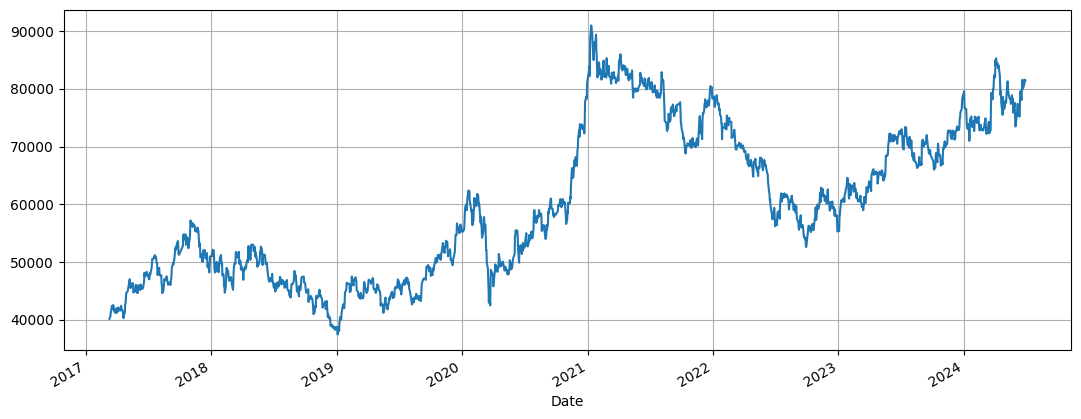

In [47]:
samsung["Close"].plot(grid=True, figsize=(13, 5))

## 데이터 예측 후 실제 데이터와 맞는지 확인

In [48]:
samsung_tmp = samsung[:"2024-02-01"]
samsung_tmp.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-26,73700.0,74500.0,73300.0,73400.0,73067.953125,11160062
2024-01-29,73800.0,75200.0,73500.0,74400.0,74063.429688,13976521
2024-01-30,75000.0,75300.0,73700.0,74300.0,73963.882812,12244418
2024-01-31,73400.0,74000.0,72500.0,72700.0,72371.117188,15703560
2024-02-01,73000.0,74200.0,72900.0,73600.0,73267.046875,19881033


데이터 형태를 맞추기 위함

In [49]:
samsung_trunc = pd.DataFrame({
    "ds":samsung_tmp.index,
    "y":samsung_tmp["Close"]
})
samsung_trunc.reset_index(inplace=True)
del samsung_trunc["Date"]
samsung_trunc

,ds,y
0,2017-03-10,40180.0
1,2017-03-13,40600.0
2,2017-03-14,41360.0
3,2017-03-15,41400.0
4,2017-03-16,41840.0
...,...,...
1688,2024-01-26,73400.0
1689,2024-01-29,74400.0
1690,2024-01-30,74300.0
1691,2024-01-31,72700.0


prophet 함수를 통해 학습

In [56]:
m = Prophet(yearly_seasonality=True, daily_seasonality=True)
m.fit(samsung_trunc)
future = m.make_future_dataframe(periods=150)
forecast = m.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp90_c6pdk/crqqq7xq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp90_c6pdk/n9eduvmi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71170', 'data', 'file=/tmp/tmp90_c6pdk/crqqq7xq.json', 'init=/tmp/tmp90_c6pdk/n9eduvmi.json', 'output', 'file=/tmp/tmp90_c6pdk/prophet_modelpo3847fg/prophet_model-20240715131206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:12:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:12:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [57]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1838,2024-06-26,78350.361666,74417.096312,85006.813731,74480.067475,82047.393182,1665.465754,1665.465754,1665.465754,1616.51308,1616.51308,1616.51308,65.438805,65.438805,65.438805,-16.486131,-16.486131,-16.486131,0.0,0.0,0.0,80015.827420
1839,2024-06-27,78385.484888,74670.961095,85262.886815,74494.818734,82122.053697,1636.609025,1636.609025,1636.609025,1616.51308,1616.51308,1616.51308,78.856451,78.856451,78.856451,-58.760507,-58.760507,-58.760507,0.0,0.0,0.0,80022.093912
1840,2024-06-28,78420.608109,74778.022148,85135.720884,74469.683218,82224.202958,1591.403046,1591.403046,1591.403046,1616.51308,1616.51308,1616.51308,65.714820,65.714820,65.714820,-90.824854,-90.824854,-90.824854,0.0,0.0,0.0,80012.011155
1841,2024-06-29,78455.731331,74577.914307,84845.326003,74444.547701,82326.352219,1302.339939,1302.339939,1302.339939,1616.51308,1616.51308,1616.51308,-202.063903,-202.063903,-202.063903,-112.109238,-112.109238,-112.109238,0.0,0.0,0.0,79758.071270
1842,2024-06-30,78490.854553,74104.896919,84934.407169,74428.326359,82427.258642,1292.214015,1292.214015,1292.214015,1616.51308,1616.51308,1616.51308,-202.064169,-202.064169,-202.064169,-122.234896,-122.234896,-122.234896,0.0,0.0,0.0,79783.068568


- 검정색 점 : 실제 데이터
- 파란색 실선 : 예측 데이터

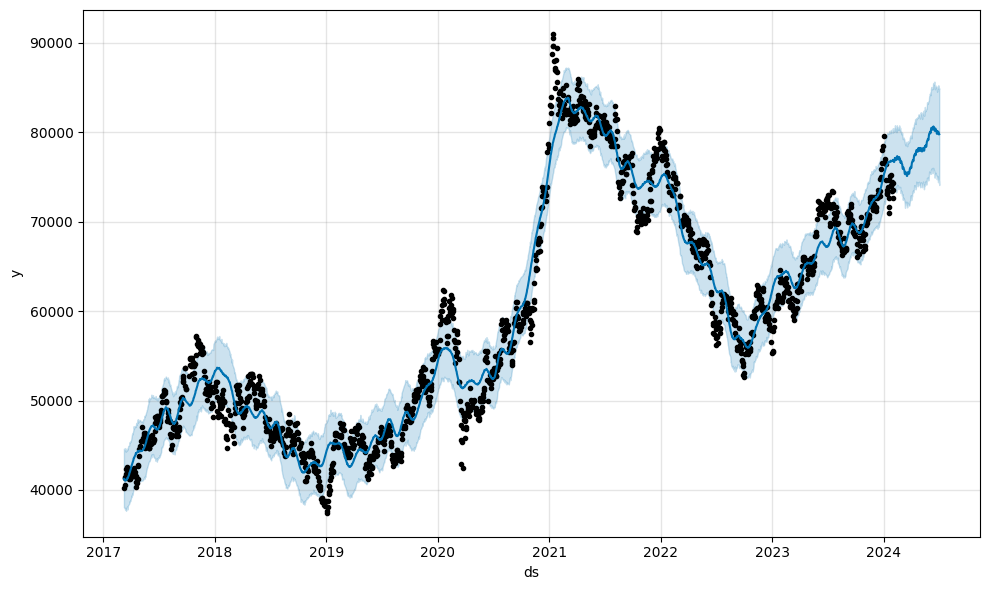

In [58]:
m.plot(forecast[["ds", "yhat", "yhat_upper", "yhat_lower"]]);

데이터 트렌드 파악

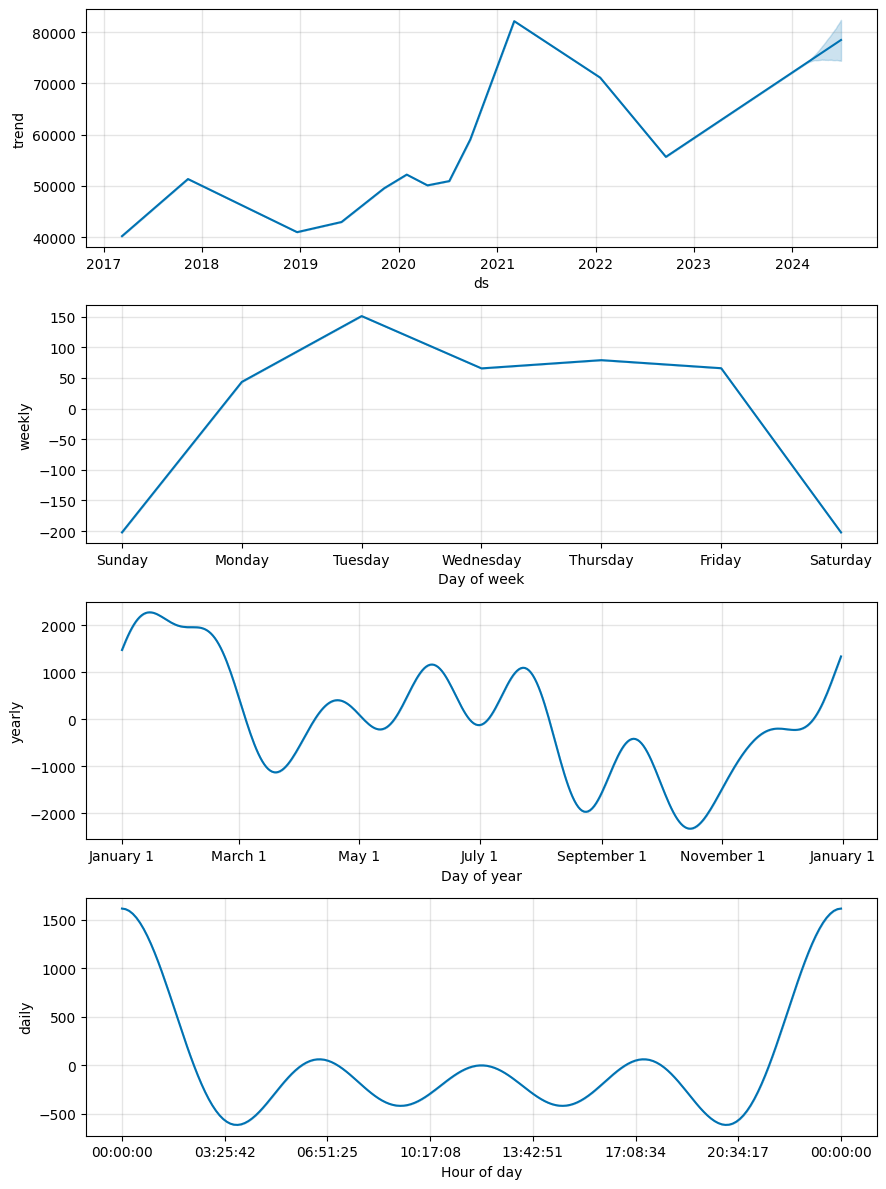

In [59]:
m.plot_components(forecast);

In [60]:
%matplotlib inline

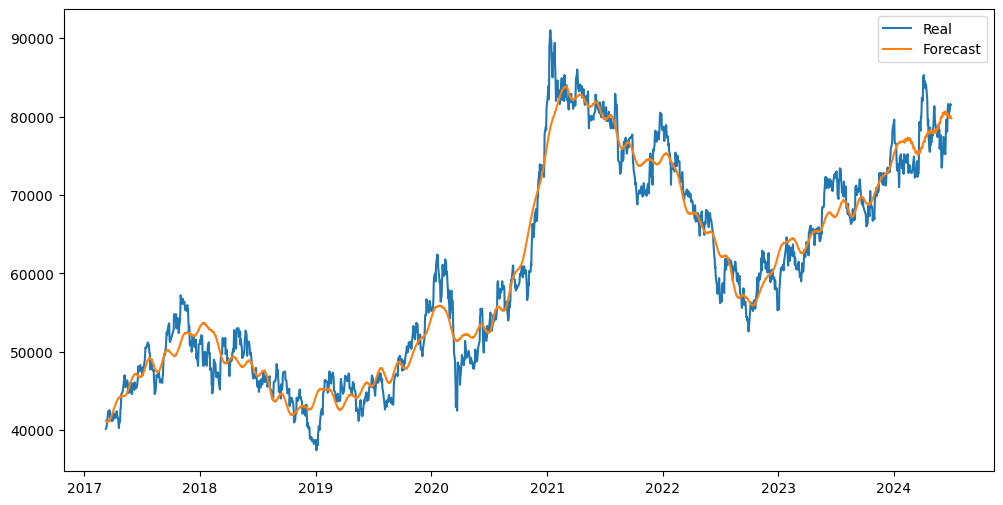

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(samsung.index, samsung["Close"], label="Real")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast")
plt.legend()
plt.show()